# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                    
Sample_031  Q15828                                               16.308
Sample_004  A0A140T962;A0A140T9B3;A0A140T9J9;A0A1W2PR11;Q29963   17.582
Sample_059  A2RU67                                               12.411
Sample_015  Q9UQ52                                               13.976
Sample_095  I3L145;P04278                                        16.605
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                             
Sample_051  B5MCX6;F8W8J5;Q8TAG5;Q8TAG5-2                 15.450
Sample_095  E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2    5.835
Sample_154  Q09327                                        12.925
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.312
            A0A075B6Q5                 13.454
            A0A075B6R2                 12.236
            A0A075B6S5                 11.841
            A0A087WSY4                 13.727
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.454
            Q9UI40;Q9UI40-2            12.196
            Q9UIW2                     12.402
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.999
            Q9UP79                     12.354
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.472,15.050,16.842,19.863,13.908,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.713,19.067,...,15.528,15.576,12.437,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.205,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.028,17.705,17.039,14.758,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,13.130,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,13.135,15.345,17.084,18.708,14.249,19.433,10.443,7.770
Sample_207,15.739,16.877,15.469,16.898,14.374,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.312,...,16.012,15.178,12.974,15.050,16.842,19.863,12.639,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.108,19.067,16.188,...,15.528,15.576,12.883,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.418,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.863,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.716,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.672,15.345,17.084,18.708,14.249,19.433,12.886,13.580
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 408.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.44it/s]

100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.86it/s]

100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.17it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.88it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.78it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.58it/s]

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.64it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.26it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.94it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.62it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.69it/s]

100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.43it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.69it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.92it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.58it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.47it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.54it/s]

100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

100%|██████████| 8/8 [00:02<00:00,  2.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.51it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.43it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.58it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.44it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.69it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.85it/s]

100%|██████████| 9/9 [00:03<00:00,  2.90it/s]

100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.64it/s]

 30%|███       | 3/10 [00:00<00:01,  4.03it/s]

 40%|████      | 4/10 [00:01<00:01,  3.25it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.72it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.33it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.28it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.43it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.55it/s]

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.78it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.64it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.56it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.80it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.54it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.56it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.60it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.61it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.69it/s]

100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

100%|██████████| 11/11 [00:03<00:00,  2.90it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.53it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.48it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.05it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.59it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.34it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.38it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.40it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.51it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.53it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.55it/s]

100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.17it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.90it/s]

 31%|███       | 4/13 [00:01<00:02,  3.58it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.00it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.63it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.44it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.42it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.51it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.61it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.64it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.72it/s]

100%|██████████| 13/13 [00:04<00:00,  2.39it/s]

100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.30it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.74it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.09it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.89it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.75it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.73it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.70it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.49it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.36it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.23it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.20it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.33it/s]

100%|██████████| 14/14 [00:05<00:00,  2.35it/s]

100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.17it/s]

 20%|██        | 3/15 [00:00<00:02,  4.57it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.91it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.68it/s]

 40%|████      | 6/15 [00:01<00:02,  3.44it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.79it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.47it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.13it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  1.90it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.87it/s]

 80%|████████  | 12/15 [00:04<00:01,  1.97it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.12it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.23it/s]

100%|██████████| 15/15 [00:06<00:00,  2.27it/s]

100%|██████████| 15/15 [00:06<00:00,  2.48it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.059 0.022          0.847 0.246       0.136   
2             0.005 0.004      0.053 0.017          0.707 0.092       0.603   
3             0.004 0.003      0.051 0.014          0.683 0.091       0.614   
4             0.004 0.001      0.049 0.011          0.710 0.082       0.667   
5             0.004 0.000      0.048 0.009          0.717 0.074       0.682   
6             0.004 0.002      0.049 0.010          0.801 0.088       0.830   
7             0.004 0.002      0.049 0.009          0.799 0.089       0.822   
8             0.004 0.000      0.048 0.013          0.805 0.088       0.805   
9             0.004 0.004      0.047 0.018          0.806 0.085       0.794   
10            0.004 0.003      0.049 0.015          0.808 0.082       0.790   
11            0.004 0.000      0.051 0.012          0.838 0.079       0.816   
12            0.005 0.004      0.061 0.024          0.821 0.082       0.814   
13            0.006 0.005      0.060 0.024          0.818 0.077       0.812   
14            0.006 0.005      0.073 0.027          0.800 0.078       0.808   
15            0.004 0.002      0.060 0.022          0.811 0.069       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.225 0.127                  0.560 0.042        0.857   
2          0.106   0.645 0.080                  0.708 0.060        0.787   
3          0.111   0.641 0.083                  0.701 0.062        0.774   
4          0.112   0.681 0.074                  0.732 0.055        0.784   
5          0.110   0.694 0.074                  0.742 0.057        0.812   
6          0.098   0.811 0.074                  0.838 0.065        0.902   
7          0.099   0.806 0.074                  0.833 0.064        0.900   
8          0.104   0.801 0.077                  0.830 0.066        0.900   
9          0.098   0.796 0.072                  0.826 0.061        0.914   
10         0.097   0.795 0.071                  0.825 0.059        0.913   
11         0.096   0.823 0.068                  0.849 0.056        0.915   
12         0.100   0.813 0.069                  0.841 0.059        0.914   
13         0.104   0.811 0.072                  0.839 0.060        0.911   
14         0.099   0.800 0.070                  0.829 0.060        0.910   
15         0.099   0.806 0.067                  0.835 0.056        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.085        210.000 0.000  
2          0.066                  0.761 0.084        210.000 0.000  
3          0.066                  0.750 0.084        210.000 0.000  
4          0.063                  0.749 0.084        210.000 0.000  
5          0.063                  0.784 0.082        210.000 0.000  
6          0.048                  0.877 0.058        210.000 0.000  
7          0.049                  0.872 0.061        210.000 0.000  
8          0.049                  0.870 0.063        210.000 0.000  
9          0.044                  0.898 0.050        210.000 0.000  
10         0.043                  0.897 0.049        210.000 0.000  
11         0.046                  0.904 0.047        210.000 0.000  
12         0.047                  0.904 0.047        210.000 0.000  
13         0.049                  0.901 0.048        210.000 0.000  
14         0.049                  0.900 0.049        210.000 0.000  
15         0.048                  0.901 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 504.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.18it/s]

100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.96it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.29it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.61it/s]

100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.95it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.96it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.31it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.53it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.32it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.89it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.58it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.52it/s]

100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.56it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.33it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.04it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.94it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.89it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.81it/s]

100%|██████████| 8/8 [00:02<00:00,  2.55it/s]

100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.10it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.66it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.21it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.26it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.28it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.35it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.05it/s]

100%|██████████| 9/9 [00:04<00:00,  1.89it/s]

100%|██████████| 9/9 [00:04<00:00,  2.18it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.78it/s]

 30%|███       | 3/10 [00:00<00:01,  3.76it/s]

 40%|████      | 4/10 [00:01<00:02,  2.71it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.23it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.02it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.75it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.66it/s]

100%|██████████| 10/10 [00:04<00:00,  1.70it/s]

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.11it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.22it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.65it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.34it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.07it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.12it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.81it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.71it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.64it/s]

100%|██████████| 11/11 [00:05<00:00,  1.70it/s]

100%|██████████| 11/11 [00:05<00:00,  2.16it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.04it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.90it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.40it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.23it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.05it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.57it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.22it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.83it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.67it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.60it/s]

100%|██████████| 12/12 [00:05<00:00,  1.68it/s]

100%|██████████| 12/12 [00:05<00:00,  2.15it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.50it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.22it/s]

 31%|███       | 4/13 [00:01<00:02,  3.11it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.93it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.86it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.93it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.52it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.22it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.03it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.02it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.10it/s]

100%|██████████| 13/13 [00:05<00:00,  2.02it/s]

100%|██████████| 13/13 [00:05<00:00,  2.39it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.38it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.62it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.62it/s]

 36%|███▌      | 5/14 [00:01<00:04,  2.24it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.04it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.95it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.80it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.67it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.72it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.90it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.01it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.16it/s]

100%|██████████| 14/14 [00:06<00:00,  2.22it/s]

100%|██████████| 14/14 [00:06<00:00,  2.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.03it/s]

 20%|██        | 3/15 [00:00<00:02,  4.26it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.71it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.41it/s]

 40%|████      | 6/15 [00:01<00:02,  3.32it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.65it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.32it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.22it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  1.97it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.93it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.82it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.76it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.76it/s]

100%|██████████| 15/15 [00:06<00:00,  1.81it/s]

100%|██████████| 15/15 [00:06<00:00,  2.23it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.065 0.023          0.821 0.291       0.147   
2             0.005 0.005      0.065 0.031          0.617 0.124       0.476   
3             0.005 0.005      0.076 0.029          0.817 0.079       0.723   
4             0.005 0.003      0.075 0.030          0.813 0.078       0.780   
5             0.006 0.006      0.071 0.027          0.806 0.080       0.765   
6             0.004 0.003      0.064 0.030          0.800 0.092       0.760   
7             0.005 0.003      0.064 0.023          0.827 0.091       0.795   
8             0.006 0.005      0.068 0.026          0.824 0.095       0.791   
9             0.005 0.004      0.066 0.026          0.817 0.081       0.853   
10            0.006 0.005      0.064 0.024          0.808 0.078       0.853   
11            0.005 0.004      0.067 0.027          0.801 0.079       0.842   
12            0.004 0.002      0.056 0.017          0.816 0.075       0.831   
13            0.006 0.006      0.069 0.028          0.811 0.072       0.825   
14            0.007 0.006      0.070 0.031          0.810 0.071       0.821   
15            0.005 0.003      0.057 0.021          0.811 0.070       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.090   0.241 0.132                  0.566 0.044        0.851   
2          0.119   0.527 0.096                  0.625 0.064        0.709   
3          0.105   0.762 0.071                  0.801 0.056        0.902   
4          0.105   0.791 0.070                  0.823 0.058        0.905   
5          0.113   0.780 0.076                  0.814 0.062        0.900   
6          0.112   0.775 0.082                  0.809 0.067        0.897   
7          0.105   0.805 0.074                  0.834 0.063        0.906   
8          0.106   0.802 0.077                  0.831 0.065        0.904   
9          0.091   0.831 0.067                  0.855 0.059        0.914   
10         0.090   0.826 0.060                  0.850 0.053        0.913   
11         0.094   0.817 0.066                  0.843 0.057        0.911   
12         0.082   0.820 0.061                  0.846 0.053        0.914   
13         0.069   0.815 0.048                  0.841 0.041        0.917   
14         0.077   0.812 0.051                  0.839 0.045        0.918   
15         0.075   0.814 0.051                  0.840 0.045        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.088        210.000 0.000  
2          0.079                  0.658 0.097        210.000 0.000  
3          0.045                  0.881 0.056        210.000 0.000  
4          0.045                  0.884 0.054        210.000 0.000  
5          0.049                  0.880 0.059        210.000 0.000  
6          0.051                  0.876 0.060        210.000 0.000  
7          0.053                  0.889 0.061        210.000 0.000  
8          0.053                  0.888 0.061        210.000 0.000  
9          0.048                  0.902 0.051        210.000 0.000  
10         0.046                  0.899 0.049        210.000 0.000  
11         0.048                  0.899 0.048        210.000 0.000  
12         0.046                  0.899 0.048        210.000 0.000  
13         0.043                  0.904 0.044        210.000 0.000  
14         0.043                  0.908 0.044        210.000 0.000  
15         0.043                  0.907 0.044 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 913.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.80it/s]

100%|██████████| 3/3 [00:00<00:00, 17.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.66it/s]

100%|██████████| 4/4 [00:00<00:00, 13.70it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 24.00it/s]

100%|██████████| 5/5 [00:00<00:00, 18.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.80it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.07it/s]

100%|██████████| 6/6 [00:00<00:00, 14.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.75it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.86it/s]

100%|██████████| 7/7 [00:00<00:00, 14.48it/s]

100%|██████████| 7/7 [00:00<00:00, 15.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.57it/s]

 50%|█████     | 4/8 [00:00<00:00, 14.74it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 12.59it/s]

100%|██████████| 8/8 [00:00<00:00, 12.09it/s]

100%|██████████| 8/8 [00:00<00:00, 12.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.57it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.63it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.20it/s]

100%|██████████| 9/9 [00:00<00:00, 15.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.51it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.04it/s]

 80%|████████  | 8/10 [00:00<00:00, 12.41it/s]

100%|██████████| 10/10 [00:00<00:00, 12.20it/s]

100%|██████████| 10/10 [00:00<00:00, 12.96it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.53it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.48it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.48it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.15it/s]

100%|██████████| 11/11 [00:00<00:00, 12.57it/s]

100%|██████████| 11/11 [00:00<00:00, 12.89it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.48it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.45it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.48it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.65it/s]

100%|██████████| 12/12 [00:00<00:00, 13.01it/s]

100%|██████████| 12/12 [00:00<00:00, 13.82it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.72it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.24it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.68it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.88it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.53it/s]

100%|██████████| 13/13 [00:00<00:00, 12.99it/s]

100%|██████████| 13/13 [00:00<00:00, 13.70it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.86it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.11it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.77it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.58it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.73it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.95it/s]

100%|██████████| 14/14 [00:01<00:00, 10.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.70it/s]

 40%|████      | 6/15 [00:00<00:00, 14.60it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 12.97it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.73it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.04it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 13.22it/s]

100%|██████████| 15/15 [00:01<00:00, 12.79it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.062 0.024          0.120 0.328       0.009   
2             0.004 0.003      0.051 0.020          0.599 0.094       0.472   
3             0.005 0.004      0.066 0.025          0.581 0.117       0.458   
4             0.004 0.002      0.050 0.010          0.580 0.110       0.458   
5             0.005 0.004      0.061 0.020          0.563 0.112       0.456   
6             0.004 0.002      0.052 0.016          0.577 0.107       0.471   
7             0.005 0.003      0.062 0.024          0.571 0.108       0.464   
8             0.004 0.003      0.051 0.014          0.561 0.107       0.465   
9             0.006 0.005      0.060 0.023          0.600 0.089       0.548   
10            0.004 0.000      0.053 0.017          0.605 0.088       0.555   
11            0.005 0.004      0.064 0.024          0.619 0.102       0.572   
12            0.004 0.002      0.055 0.015          0.616 0.104       0.568   
13            0.006 0.005      0.069 0.025          0.601 0.097       0.554   
14            0.004 0.002      0.054 0.017          0.651 0.102       0.583   
15            0.006 0.005      0.066 0.027          0.646 0.101       0.579   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.027   0.017 0.050                  0.503 0.015        0.741   
2          0.109   0.521 0.089                  0.619 0.059        0.694   
3          0.126   0.505 0.108                  0.607 0.074        0.704   
4          0.118   0.506 0.102                  0.607 0.070        0.699   
5          0.125   0.498 0.108                  0.600 0.073        0.692   
6          0.120   0.513 0.102                  0.609 0.071        0.688   
7          0.119   0.506 0.103                  0.605 0.072        0.683   
8          0.120   0.502 0.101                  0.599 0.069        0.675   
9          0.141   0.566 0.105                  0.643 0.075        0.719   
10         0.147   0.572 0.109                  0.648 0.078        0.716   
11         0.140   0.589 0.108                  0.659 0.081        0.724   
12         0.133   0.586 0.105                  0.655 0.081        0.720   
13         0.148   0.570 0.112                  0.646 0.075        0.719   
14         0.135   0.609 0.106                  0.678 0.074        0.740   
15         0.128   0.605 0.102                  0.674 0.072        0.736   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.656 0.080        210.000 0.000  
2          0.073                  0.670 0.076        210.000 0.000  
3          0.081                  0.660 0.087        210.000 0.000  
4          0.079                  0.649 0.085        210.000 0.000  
5          0.077                  0.635 0.086        210.000 0.000  
6          0.075                  0.635 0.085        210.000 0.000  
7          0.076                  0.627 0.087        210.000 0.000  
8          0.076                  0.615 0.084        210.000 0.000  
9          0.066                  0.662 0.081        210.000 0.000  
10         0.067                  0.655 0.080        210.000 0.000  
11         0.066                  0.662 0.080        210.000 0.000  
12         0.066                  0.656 0.081        210.000 0.000  
13         0.073                  0.663 0.090        210.000 0.000  
14         0.066                  0.693 0.079        210.000 0.000  
15         0.067                  0.687 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,14,13
score_time,14,3,13
test_precision,1,7,14
test_recall,6,9,14
test_f1,11,9,14
test_balanced_accuracy,11,9,14
test_roc_auc,11,14,1
test_average_precision,12,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.45it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.18it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.45it/s]

 36%|███▌      | 5/14 [00:01<00:04,  2.16it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.18it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.18it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.27it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.28it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.55it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.67it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.11it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.91it/s]

100%|██████████| 14/14 [00:06<00:00,  1.84it/s]

100%|██████████| 14/14 [00:06<00:00,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1066.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.77it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.76it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.49it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.19it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.39it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.44it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.43it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.44it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

100%|██████████| 11/11 [00:04<00:00,  2.44it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


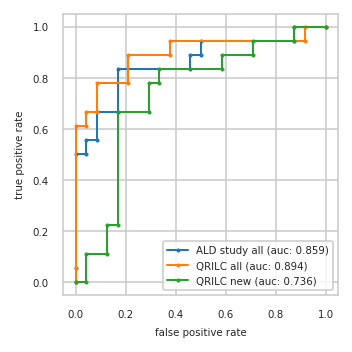

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.500     0.000 0.611     0.042 0.111
3          0.042 0.500     0.042 0.611     0.125 0.111
4          0.042 0.556     0.042 0.667     0.125 0.222
5          0.083 0.556     0.083 0.667     0.167 0.222
6          0.083 0.667     0.083 0.778     0.167 0.667
7          0.167 0.667     0.208 0.778     0.292 0.667
8          0.167 0.833     0.208 0.889     0.292 0.778
9          0.458 0.833     0.375 0.889     0.333 0.778
10         0.458 0.889     0.375 0.944     0.333 0.833
11         0.500 0.889     0.917 0.944     0.583 0.833
12         0.500 0.944     0.917 1.000     0.583 0.889
13         0.875 0.944     1.000 1.000     0.708 0.889
14         0.875 1.000       NaN   NaN     0.708 0.944
15         1.000 1.000       NaN   NaN     0.875 0.944
16           NaN   NaN       NaN   NaN     0.875 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,P01597;P04432,Q15848,None
2,D6RF86;P55285;P55285-2,P15151-2,None
3,P61981,P61981,None
4,P04075,Q9Y2T3;Q9Y2T3-3,None
5,Q02818,P14174,None
6,P14174,P04075,None
7,P14618,Q14894,None
8,P00338;P00338-3,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


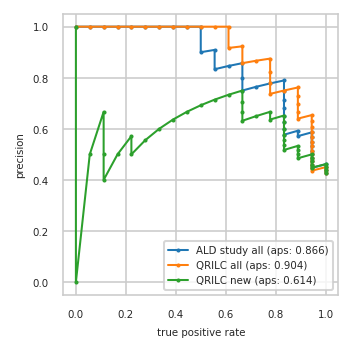

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.436 0.944     0.462 1.000
4          0.447 0.944     0.447 0.944     0.447 0.944
5          0.459 0.944     0.459 0.944     0.459 0.944
6          0.472 0.944     0.472 0.944     0.472 0.944
7          0.486 0.944     0.486 0.944     0.486 0.944
8          0.500 0.944     0.500 0.944     0.500 0.944
9          0.515 0.944     0.515 0.944     0.485 0.889
10         0.531 0.944     0.531 0.944     0.500 0.889
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.577 0.833     0.654 0.944     0.577 0.833
17         0.600 0.833     0.640 0.889     0.600 0.833
18         0.625 0.833     0.667 0.889     0.625 0.833
19         0.652 0.833     0.696 0.889     0.652 0.833
20         0.682 0.833     0.727 0.889     0.636 0.778
21         0.714 0.833     0.762 0.889     0.667 0.778
22         0.750 0.833     0.750 0.833     0.650 0.722
23         0.789 0.833     0.737 0.778     0.632 0.667
24         0.778 0.778     0.778 0.778     0.667 0.667
25         0.765 0.722     0.824 0.778     0.706 0.667
26         0.750 0.667     0.875 0.778     0.750 0.667
27         0.800 0.667     0.867 0.722     0.733 0.611
28         0.857 0.667     0.857 0.667     0.714 0.556
29         0.846 0.611     0.923 0.667     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.909 0.556     1.000 0.611     0.636 0.389
32         0.900 0.500     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


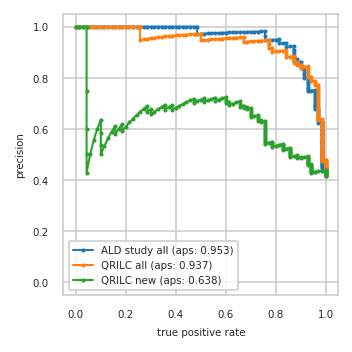

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


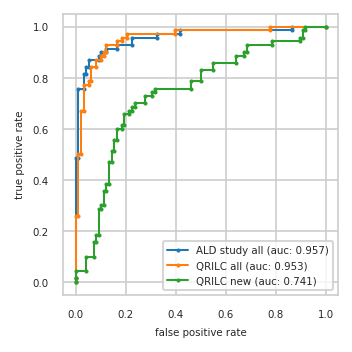

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}